# Метод максимального правдоподобия

## Оценка одномерной выборки

In [2]:
import numpy as np 

size = 10000 # Number of observations
mu = 3 # Mean
sigma = 2 # Standard deviation 
sample = np.random.normal(loc=mu, scale=sigma, size=size)

### Явное решение

In [3]:
mu_hat = sample.mean()
sigma_hat = np.sqrt(
        np.sum(
            (sample - sample.mean())**2
        ) 
        / size
    )

print(f"Estimated mu: {mu_hat}")
print(f"Estimated sigma: {sigma_hat}")

Estimated mu: 3.0313289904137104
Estimated sigma: 1.9824510872015


### Численное решение

In [4]:
    
def log_likelihood_factory(sample: np.ndarray):

    def log_likelihood(params):
        mu, sigma = params

        n = len(sample)

        lik =   - 0.5 * n * np.log(2 * np.pi) \
                - 0.5 * n * np.log(sigma ** 2) \
                - (0.5 / sigma **2) * np.sum(
                (sample - mu)**2
            ) 
        
        # For maximization
        return  - lik
    
    return log_likelihood


def log_likelihood_grad_factory(sample: np.ndarray):

    def log_likelihood_grad(params):
        mu, sigma = params

        n = len(sample)

        mu_part =  (1 / sigma **2) * (np.sum(sample) - n * mu)
        sigma_part =  (0.5 / sigma **2) \
                        *  ((1 / sigma **2) *np.sum((sample - mu)**2) - n)
        
        # For maximization
        return - np.array([mu_part, sigma_part])
    
    return log_likelihood_grad

In [5]:
from scipy.optimize import minimize

x0 = np.random.uniform(size=2)
res = minimize(
    log_likelihood_factory(sample), 
    x0,
    jac=log_likelihood_grad_factory(sample)
)

In [6]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 21032.725351454577
        x: [ 3.031e+00  1.982e+00]
      nit: 19
      jac: [ 4.699e-08 -4.372e-07]
 hess_inv: [[ 3.930e-04  7.185e-07]
            [ 7.185e-07  7.659e-04]]
     nfev: 24
     njev: 24

## Марковская цепь

**Марковская цепь** — это математическая модель стохастического процесса, в которой вероятность перехода в следующее состояние зависит только от текущего состояния и не зависит от предыдущих состояний. Такая характеристика называется *свойством Маркова* или свойством отсутствия памяти.

Формально, последовательность случайных переменных $( X_1, X_2, \ldots, X_n )$ образует Марковскую цепь, если выполняется следующее условие:

$$
P(X_{n+1} = x \mid X_1 = x_1, X_2 = x_2, \ldots, X_n = x_n) = P(X_{n+1} = x \mid X_n = x_n)
$$

где $ P $ обозначает вероятность, а $ X_n $ — состояние в момент времени $ n $.



In [7]:
from tqdm import trange
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go


class MarkovChain:
    def __init__(self, nodes: list[int], transition_matrix: np.ndarray):
        """
        Initializes a Markov chain with the given nodes and transition matrix.

        Args:
            nodes (list[int]): List of node identifiers.
            transition_matrix (np.ndarray): Square matrix representing transition probabilities between nodes.
        
        Raises:
            AssertionError: If the dimensions of the transition matrix do not match the number of nodes.
        """
        assert len(nodes) == transition_matrix.shape[0]
        assert len(nodes) == transition_matrix.shape[1]

        self.nodes = nodes 
        self.transition_matrix = transition_matrix

        self.graph = nx.DiGraph()
        for node in self.nodes:
            self.graph.add_node(node)

        for i, start_node in enumerate(self.nodes):
            for j, end_node in enumerate(self.nodes):
                probability = self.transition_matrix[i, j]
                if probability > 0:
                    self.graph.add_edge(start_node, end_node, weight=probability, label=f"{probability:.2f}")

    def generate_trajectory(self, length: int) -> np.ndarray:
        """
        Generates a trajectory of the Markov chain starting from a random node.

        Args:
            length (int): Length of the desired trajectory.

        Returns:
            np.ndarray: Array representing the sequence of nodes in the trajectory.
        """
        initial_node = np.random.choice(self.nodes, size=1)

        cur_node = initial_node
        trajectory = [initial_node]
        
        for _ in trange(length):
            cur_probs = self.transition_matrix[cur_node, :].ravel()
            mask = (cur_probs > 0).ravel()
            neighbours = self.nodes[mask]
            neighbours_probs = cur_probs[mask]
            cur_node = np.random.choice(neighbours, size=1, p=neighbours_probs)

            trajectory.append(cur_node)

        return np.array(trajectory).ravel()

    def plot(self):
        """
        Plots the Markov chain graph with nodes and edges. The edge labels represent transition probabilities.
        """
        # Position the nodes using a layout
        pos = nx.spring_layout(self.graph)

        # Draw the graph
        nx.draw(self.graph, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=12, font_weight='bold', arrows=True, connectionstyle='arc3,rad=0.2')

        # Draw edge labels (probabilities)
        edge_labels = nx.get_edge_attributes(self.graph, 'label')
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, font_size=10)

        # Show the plot
        plt.show()

    def plot_trajectory(self, trajectory: np.ndarray):
        """
        Plots the trajectory of the Markov chain over time, using Plotly for animation.

        Args:
            trajectory (np.ndarray): Array representing the sequence of nodes in the trajectory.
        """
        pos = nx.spring_layout(self.graph)
        edge_x, edge_y = [], []
        for edge in self.graph.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])

        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=1, color='#888'),
            hoverinfo='none',
            mode='lines')

        node_x, node_y = zip(*[pos[n] for n in self.graph.nodes()])
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            text=[str(node) for node in self.graph.nodes()],
            textposition='top center',
            hoverinfo='text',
            marker=dict(size=20, color='lightblue'))

        frames = []
        for i in range(len(trajectory)):
            frame_node_trace = go.Scatter(
                x=node_x, y=node_y,
                mode='markers+text',
                text=[str(node) for node in self.graph.nodes()],
                textposition='top center',
                hoverinfo='text',
                marker=dict(size=[30 if n == trajectory[i] else 20 for n in self.graph.nodes()],
                            color=['red' if n == trajectory[i] else 'lightblue' for n in self.graph.nodes()]))
            frames.append(go.Frame(data=[edge_trace, frame_node_trace]))

        layout = go.Layout(
            showlegend=False,
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            template='plotly_white',
            updatemenus=[{
                "buttons": [{
                    "args": [None, {"frame": {"duration": 500, "redraw": True}, 
                                    "fromcurrent": True, "transition": {"duration": 300}}],
                    "label": "Play",
                    "method": "animate"}],
                "direction": "left",
                "pad": {"r": 10, "t": 87},
                "showactive": False,
                "type": "buttons",
                "x": 0.1,
                "xanchor": "right",
                "y": 0,
                "yanchor": "top"}])

        fig = go.Figure(data=[edge_trace, node_trace], frames=frames, layout=layout)
        fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
        fig.show()


In [8]:
n_nodes = 5

def generate_markov_chain(n_nodes: int) -> MarkovChain:
    """
    Generates a random Markov chain with a specified number of nodes.

    Args:
        n_nodes (int): The number of nodes in the Markov chain.

    Returns:
        MarkovChain: An instance of the MarkovChain class initialized with the generated nodes and transition matrix.

    Notes:
        Each node has a randomly chosen number of neighbors and transition probabilities.
    """
    nodes = np.arange(n_nodes)
    transition_matrix = np.zeros([n_nodes, n_nodes])

    for node in nodes:
        other_nodes = [x for x in nodes if x != node]
        n_other_nodes = len(other_nodes)
        n_neighbours = np.random.randint(1, n_other_nodes)
        neighbours = np.random.choice(other_nodes, n_neighbours, replace=False)

        logits = np.random.uniform(size=n_neighbours)
        probs = logits / logits.sum()

        # Just to fix floating point error
        # Sum now will be 1.0 instead of 0.999999
        probs[0] += 1 - probs.sum()

        for (neighbour, prob) in zip(neighbours, probs):
            transition_matrix[node, neighbour] = prob

    return MarkovChain(nodes=nodes, transition_matrix=transition_matrix)


In [9]:
chain = generate_markov_chain(5)

In [10]:
t = chain.generate_trajectory(10)

100%|██████████| 10/10 [00:00<00:00, 6840.03it/s]


In [11]:
chain.plot_trajectory(t)

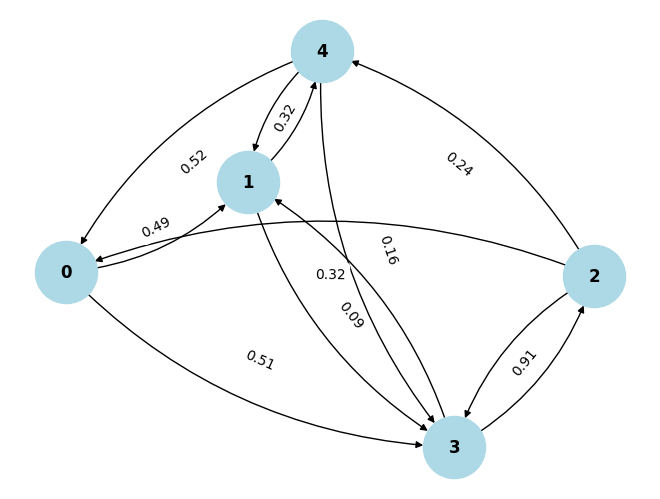

In [241]:
chain.plot()

### Явное решение

In [289]:
t = chain.generate_trajectory(1000000)
num_states = len(chain.nodes)

transition_matrix = np.zeros((num_states, num_states), dtype=int)

# Use numpy's advanced indexing to count transitions
np.add.at(transition_matrix, (t[: -1], t[1:]), 1)

transition_matrix / transition_matrix.sum(axis=1)[:, None]


100%|██████████| 1000000/1000000 [00:18<00:00, 54334.30it/s]


array([[0.        , 0.48602088, 0.        , 0.51397912, 0.        ],
       [0.        , 0.        , 0.        , 0.98468064, 0.01531936],
       [0.32542883, 0.        , 0.        , 0.43494363, 0.23962754],
       [0.        , 0.08961745, 0.91038255, 0.        , 0.        ],
       [0.52129472, 0.32118288, 0.        , 0.1575224 , 0.        ]])

In [290]:
chain.transition_matrix

array([[0.        , 0.48596867, 0.        , 0.51403133, 0.        ],
       [0.        , 0.        , 0.        , 0.98494567, 0.01505433],
       [0.3249935 , 0.        , 0.        , 0.43504221, 0.23996429],
       [0.        , 0.08967349, 0.91032651, 0.        , 0.        ],
       [0.52105567, 0.32251608, 0.        , 0.15642825, 0.        ]])

## MA(1) Процесс

**MA(1) (Модель скользящего среднего первого порядка)** — это тип временного ряда, где текущее значение ряда выражается как линейная комбинация белого шума и его предыдущего значения. MA(1) процесс моделирует зависимость текущего значения от предыдущего шума.

Формально, MA(1) процесс можно записать как:

$$
X_t = \mu + \varepsilon_t + \theta \varepsilon_{t-1}
$$

где:

- $ X_t $ — текущее значение временного ряда.
- $ \mu $ — среднее значение процесса.
- $ \varepsilon_t $ — белый шум (случайная ошибка) в момент времени $ t $, с нулевым средним и постоянной дисперсией.
- $ \theta $ — коэффициент, определяющий влияние предыдущего шума.
- $ \varepsilon_{t-1} $ — белый шум в предыдущий момент времени $ t-1 $.

In [9]:
from tqdm import trange

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go


class MA1:

    def __init__(self, theta: float, mu:float=0, sigma:float=0):

        """
         Initializes MA(1) process

         Args:

         nodes (list[int]): 
        """

        assert sigma > 0

        self.mu = mu
        self.sigma = sigma
        self.theta = theta

        
    def generate_trajectory(self, length: int, eps_0: float=0) -> np.ndarray:

        """
        Generates trajectory of MA(1) process

        Args:

            length (int): Length of output trajectory

        Returns:
            np.ndarray -- Trajectory of chain nodes
        """
        
        trajectory = []
        prev_eps = eps_0
        
        for _ in  trange(length):

            cur_eps = np.random.normal(0, self.sigma)

            cur_x = self.mu + cur_eps + self.theta * prev_eps 
            trajectory.append(cur_x)

            prev_eps = cur_eps

        return np.array(trajectory).ravel()
    

    def plot_trajectory(self, trajectory: np.ndarray):
        """
        Plots the trajectory of the MA(1) process using Plotly.

        Args:
            trajectory (np.ndarray): The trajectory of the MA(1) process to plot.
        """
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=list(range(len(trajectory))),
            y=trajectory,
            mode='lines+markers',
            name='MA(1) Trajectory'
        ))

        fig.update_layout(
            title='MA(1) Process Trajectory',
            xaxis_title='Time',
            yaxis_title='Value',
            template='plotly_dark'  # Optional: Use any template you like
        )

        fig.show()




In [10]:
ma = MA1(0.5, 5, 1)

In [11]:
t = ma.generate_trajectory(200)

100%|██████████| 200/200 [00:00<00:00, 477167.69it/s]


In [12]:
ma.plot_trajectory(t)